<a href="https://colab.research.google.com/github/KasperSmidt/ML2/blob/Deep-Learning/DL_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import zipfile
import os
from google.colab import drive

In [2]:
# URL of the dataset
url = 'https://archive.ics.uci.edu/static/public/908/realwaste.zip'

# Path to save the downloaded ZIP file
zip_path = '/content/realwaste.zip'

# Download the ZIP file
print("Downloading the dataset...")
r = requests.get(url, allow_redirects=True)
with open(zip_path, 'wb') as zip_file:
 zip_file.write(r.content)

# Extract the ZIP file
print("Extracting the dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
 zip_ref.extractall('/content/')

# Clean up the ZIP file
os.remove(zip_path)


Extracting the dataset...


In [3]:
from PIL import Image
import os

# Path to an image in your dataset (adjust the path as necessary)
image_path = '/content/realwaste-main/RealWaste/Cardboard/Cardboard_1.jpg'

# Load the image
image = Image.open(image_path)

# Print the size of the image
print(f"The image dimensions are: {image.size} (width x height)")

# If you also want to check the mode (e.g., RGB, RGBA, L (grayscale))
print(f"The image mode is: {image.mode}")

The image dimensions are: (524, 524) (width x height)
The image mode is: RGB


In [5]:
import os
import shutil
from random import seed, shuffle

# Define paths
base_path = '/content/realwaste-main'
real_waste_path = os.path.join(base_path, 'RealWaste')
train_path = os.path.join(base_path, 'training')
val_path = os.path.join(base_path, 'validation')

# Labels for classification
labels = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Paper', 'Plastic', 'Miscellaneous Trash', 'Textile Trash', 'Vegetation']

# checking training and validation directories exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Splitting the data
def split_data(source, training, validation, train_size=0.8):
    # Gather all files from the source directory
    files = os.listdir(source)
    shuffle(files)  # Shuffle the list to ensure random distribution

    # Calculate split index
    split_index = int(len(files) * train_size)

    # Split files
    train_files = files[:split_index]
    val_files = files[split_index:]

    # Copy files to respective directories
    for file in train_files:
        shutil.copy(os.path.join(source, file), os.path.join(training, file))
    for file in val_files:
        shutil.copy(os.path.join(source, file), os.path.join(validation, file))

# Iterate over each label and split the data
for label in labels:
    label_source_path = os.path.join(real_waste_path, label)
    label_train_path = os.path.join(train_path, label)
    label_val_path = os.path.join(val_path, label)

    # Ensure label directories exist in training and validation
    os.makedirs(label_train_path, exist_ok=True)
    os.makedirs(label_val_path, exist_ok=True)

    # Split and copy files
    split_data(label_source_path, label_train_path, label_val_path)


In [6]:
# Path to the training directory
train_path = '/content/realwaste-main/training'

# Count files in each category
def count_files_in_directory(directory):
    categories = os.listdir(directory)
    file_count = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):  # Ensure it's a directory
            file_count[category] = len(os.listdir(category_path))
    return file_count

# Count numbers
train_counts = count_files_in_directory(train_path)


In [7]:
# Path to the training directory
val_path = '/content/realwaste-main/validation'

# Count files in dir
def count_files_in_directory(directory):
    categories = os.listdir(directory)
    file_count = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            file_count[category] = len(os.listdir(category_path))
    return file_count

# Count numbers
val_counts = count_files_in_directory(val_path)

Training set file counts:
              Category  Training Set File Count
0                Paper                      400
1        Food Organics                      328
2            Cardboard                      368
3                Metal                      632
4           Vegetation                      348
5              Plastic                      736
6        Textile Trash                      254
7                Glass                      336
8  Miscellaneous Trash                      396

Validation set file counts:
              Category  Validation Set File Count
0                Paper                        100
1        Food Organics                         83
2            Cardboard                         93
3                Metal                        158
4           Vegetation                         88
5              Plastic                        185
6        Textile Trash                         64
7                Glass                         84
8  Miscellaneou

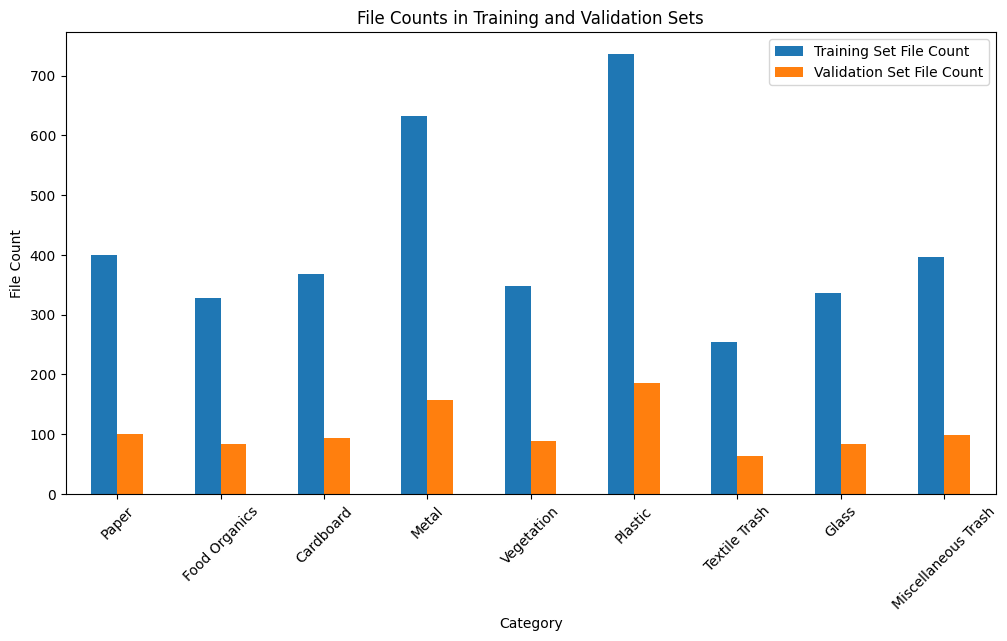

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.DataFrame(list(train_counts.items()), columns=['Category', 'Training Set File Count'])
val_df = pd.DataFrame(list(val_counts.items()), columns=['Category', 'Validation Set File Count'])

print("Training set file counts:")
print(train_df)
print("\nValidation set file counts:")
print(val_df)

# Combine the data for visualization
combined_df = pd.merge(train_df, val_df, on='Category')

# Visualize the data
combined_df.plot(kind='bar', x='Category', figsize=(12, 6))
plt.title('File Counts in Training and Validation Sets')
plt.xlabel('Category')
plt.ylabel('File Count')
plt.xticks(rotation=45)
plt.show()

In [12]:
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib

new_base_dir = pathlib.Path('/content/realwaste-main')

train_dataset = image_dataset_from_directory(
    new_base_dir / "training",
    image_size=(524, 524),
    batch_size=32,
    label_mode='categorical'
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(524, 524),
    batch_size=32,
    label_mode='categorical'
)

# Display the dataset structure
print(train_dataset.class_names)
print(validation_dataset.class_names)


Found 3798 files belonging to 9 classes.
Found 954 files belonging to 9 classes.
['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


# Building the BaseLine model


In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(524, 524, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(9, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 524, 524, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 524, 524, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 522, 522, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 261, 261, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 259, 259, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 129, 129, 64)      0         
 g2D)                                                      

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_Baseline",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
119/119 [==============================] - 66s 434ms/step - loss: 2.7658 - accuracy: 0.1980 - val_loss: 2.0262 - val_accuracy: 0.1824
Epoch 2/30
119/119 [==============================] - 45s 369ms/step - loss: 1.9095 - accuracy: 0.3073 - val_loss: 1.7651 - val_accuracy: 0.4015
Epoch 3/30
119/119 [==============================] - 44s 361ms/step - loss: 1.6506 - accuracy: 0.4071 - val_loss: 1.6222 - val_accuracy: 0.4214
Epoch 4/30
119/119 [==============================] - 43s 358ms/step - loss: 1.4370 - accuracy: 0.4945 - val_loss: 2.9203 - val_accuracy: 0.2998
Epoch 5/30
119/119 [==============================] - 44s 365ms/step - loss: 1.2277 - accuracy: 0.5729 - val_loss: 1.4380 - val_accuracy: 0.5262
Epoch 6/30
119/119 [==============================] - 44s 361ms/step - loss: 1.0165 - accuracy: 0.6538 - val_loss: 2.1363 - val_accuracy: 0.4099
Epoch 7/30
119/119 [==============================] - 43s 355ms/step - loss: 0.7980 - accuracy: 0.7367 - val_loss: 2.4181 - val_ac

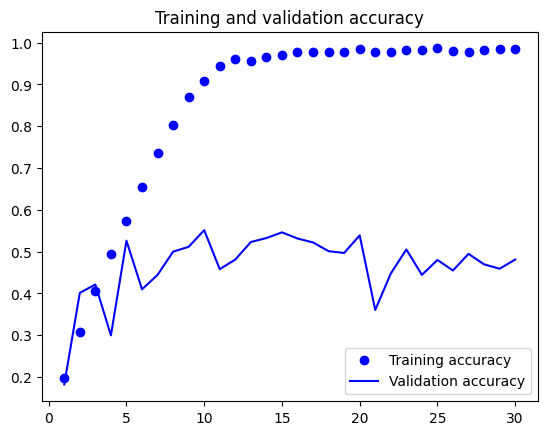

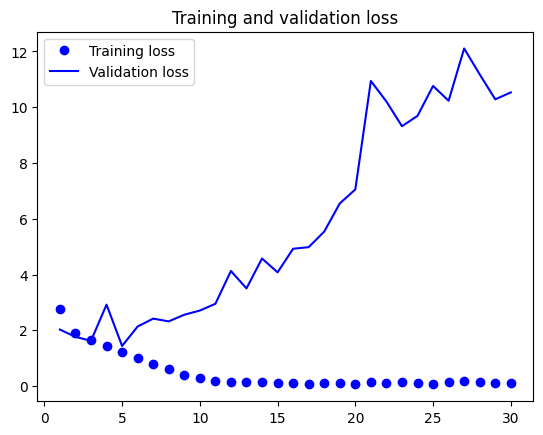

In [15]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [ ]:
inputs = keras.Input(shape=(524, 524, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Implement Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_with_augmentation",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

Epoch 1/30
119/119 [==============================] - 55s 453ms/step - loss: 0.4262 - accuracy: 0.8631 - val_loss: 1.4738 - val_accuracy: 0.6803
Epoch 2/30
119/119 [==============================] - 47s 387ms/step - loss: 0.4177 - accuracy: 0.8755 - val_loss: 3.9605 - val_accuracy: 0.5262
Epoch 3/30
119/119 [==============================] - 43s 353ms/step - loss: 0.4225 - accuracy: 0.8728 - val_loss: 1.5979 - val_accuracy: 0.6625
Epoch 4/30
119/119 [==============================] - 42s 344ms/step - loss: 0.3999 - accuracy: 0.8781 - val_loss: 1.5980 - val_accuracy: 0.6646
Epoch 5/30
119/119 [==============================] - 42s 346ms/step - loss: 0.3995 - accuracy: 0.8794 - val_loss: 1.8153 - val_accuracy: 0.6205
Epoch 6/30
119/119 [==============================] - 42s 344ms/step - loss: 0.4103 - accuracy: 0.8755 - val_loss: 2.5251 - val_accuracy: 0.5786
Epoch 7/30
119/119 [==============================] - 43s 358ms/step - loss: 0.4158 - accuracy: 0.8773 - val_loss: 1.3639 - val_ac

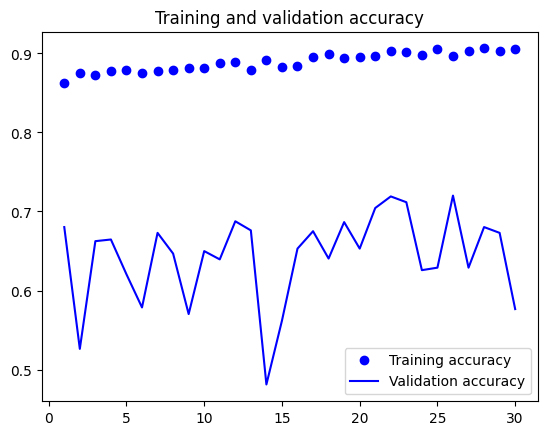

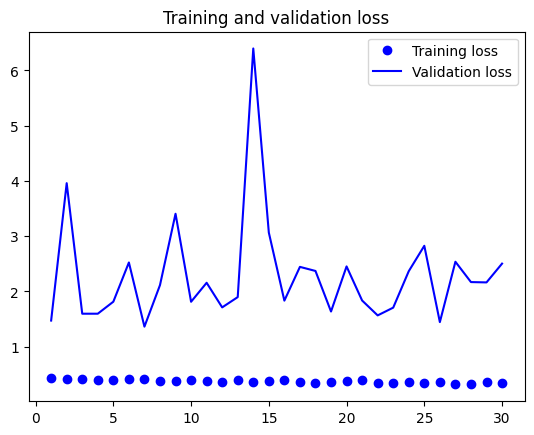

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "training",
    image_size=(524, 524),
    batch_size=64,
    label_mode='categorical'
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(524, 524),
    batch_size=64,
    label_mode='categorical'
)

# Display the dataset structure
print(train_dataset.class_names)
print(validation_dataset.class_names)


Found 3798 files belonging to 9 classes.
Found 954 files belonging to 9 classes.
['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [ ]:
inputs = keras.Input(shape=(524, 524, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)




optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# Summary of the model
model.summary()

# Implement Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 524, 524, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 524, 524, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 524, 524, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 522, 522, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 261, 261, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 259, 259, 64)      18496     
                                                           

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="CWA_Hard_training",
        save_best_only=True,
        monitor="val_loss")
]


history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

NameError: name 'keras' is not defined